In [44]:
#Use a short time of frames to calbirate the camera#
from geometry import gen_focal_length
from camera_utils import Camera, AerialView
from geometry_3d import Rotation
from calib_losses import constrained_alpha_beta_fov_loss
import numpy as np
import os
import cv2
from scipy import optimize
import argparse
import json

from visualize import create_black_board, draw_text, vis_xyz_as_images, vis_box_pairs
from datasets_v3_v3 import BoxDataLoader
from utils import load_seq_info, save_to_json


from const import MOT17_SEQ_NAMES, MOT17_TRAIN_SEQ_NAMES, MOT20_TRAIN_SEQ_NAMES, RANDOM_COLORS
from yolox.camera.img_vis import draw_box, draw_corners, draw_boxes, draw_text

import time

def gen_dir(folder):
    if not os.path.exists(folder): 
        os.system(f'mkdir -p {folder}')

def get_box_pts(boxes, 
                loc = 'bottom'):
    if loc == 'center':
        box_pts = boxes[:, :2] + boxes[:, 2:] / 2
    elif loc == 'bottom':
        box_pts = boxes[:, :2].copy()
        box_pts[:, 0] += boxes[:, 2] / 2 # x + w/2
        box_pts[:, 1] += boxes[:, 3]     # y + h
    return box_pts

def get_xy_ranges(a_view, tracks):

    boxes = tracks.reshape((-1, 4))
    mask  = boxes[:, 2] * boxes[:, 3] > 0
    boxes = boxes[mask]

    xyh = a_view.compute_xyh_from_boxes(boxes)
    xmin, xmax = xyh[:, 0].min(), xyh[:, 0].max()
    ymin, ymax = xyh[:, 1].min(), xyh[:, 1].max()

    return [xmin, ymin, xmax, ymax]


def dec_calib(boxes, bounds, a_view, 
              use_core = True):

    alpha, beta, fov = bounds

    new_boxes = boxes.copy()
    if use_core:
        centers = boxes.copy()
        centers[:, :, :2] += boxes[:, :, 2:] / 2
        centers[:, :, 2]   = centers[:, :, 3] / 4
        centers[:, :, :2] -= centers[:, :, 2:] / 2
        new_boxes          = centers

    params  = (a_view, new_boxes)
    result  = optimize.differential_evolution(constrained_alpha_beta_fov_loss, [alpha, beta, fov], args = params, 
                    updating='deferred', tol = 1e-10, workers=20, disp = False, popsize=50)

    alpha, beta, fov = result.x

    return np.array([alpha, beta, fov]), result.fun

def get_params():
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset_name", type=str, default = 'mot')
    parser.add_argument("--subset",       type=str, default = 'train')    
    parser.add_argument("--seq_name",     type=str, default = 'MOT17-13-FRCNN')
    parser.add_argument("--use_gt",       action="store_true", help="use ground truth or not")
    parser.add_argument("--workers",      type=int, default = 20)
    parser.add_argument("--popsize",      type=int, default = 50) 
    parser.add_argument("--start",        type=int, default = 0)
    parser.add_argument("--window",       type=int, default = 3)
    args = parser.parse_args()
    return args

In [45]:
root_dir = os.path.abspath('../')
proj_name    = 'calib_v3'                   # dynamic update for a moving camera
dataset_name = 'mot'
subset       = 'train'
seq_name     = 'MOT17-10-FRCNN'

use_gt       = True
use_core     = True
use_ecc      = False
time_window  = 4
num_frames   = 750
multi_ecc    = False

print('------------------------------------------------\n')
seq_info_file = os.path.join(root_dir, 'datasets', 
                    dataset_name, subset,  seq_name, 'seqinfo.ini')
seq_info = load_seq_info(seq_info_file)
print(seq_info)

calib_res_dir = os.path.join(root_dir, 'calib_results_v4', dataset_name)
gen_dir(calib_res_dir)

# intialize aerial view objects for calibration
w_img, h_img = seq_info['w_img'], seq_info['h_img']
rotation     = Rotation(np.array([0, 0, 0]))
camera       = Camera(w_img = w_img, h_img = h_img, 
                        cx = w_img / 2, cy = h_img / 2)

a_view        = AerialView(camera, rotation)

# load data for calibration
if use_gt:
    track_file = os.path.join(root_dir, 'datasets', dataset_name, subset, seq_name, 'gt/gt.txt')
else:
    if seq_name in MOT17_SEQ_NAMES:
        track_file = os.path.join(root_dir, 'results', f'mot17_paper_v3/bytetrack/{seq_name}.txt')
    else:
        track_file = os.path.join(root_dir, 'results', f'mot20_paper/yolox_x_mix_mot20_ch/bytetrack/{seq_name}.txt')

boxloader    = BoxDataLoader(track_file = track_file,
                            img_size           = (w_img, h_img),
                            window             = int(seq_info['fps'] * 2),
                            stride             = seq_info['fps'] // 2,
                            height_dif_thresh  = 3,
                            front_ratio_thresh = 0.8,
                            fps                = seq_info['fps'],
                            use_ecc            = use_ecc,
                            multi_ecc          = multi_ecc,
                            img_dir            = os.path.join(root_dir, 'datasets', dataset_name, subset, seq_name, 'img1'),
                            time_window        = time_window,
                            num_frames         = num_frames)

------------------------------------------------

{'seq_name': 'MOT17-10-FRCNN', 'fps': 30, 'seq_len': 654, 'w_img': 1920, 'h_img': 1080}
track numpy shape: (73, 654, 4)
track numpy shape: (73, 654, 4)


In [46]:
start_frame_id = 0
frame_window   = time_window * seq_info['fps']
end_frame_id = start_frame_id + frame_window
ref_frame_id = start_frame_id + frame_window // 2
boxes = boxloader.get_ecc_warpped_boxes(start_frame_id, frame_window)
bounds   = ((20, 100), (-10, 10), (30, 150))
result, loss_val = dec_calib(boxes, bounds, a_view, use_core = use_core)
alpha, beta, fov = result
alpha, beta, fov = float(alpha), float(beta), float(fov)
print(f'alpha: {round(alpha, 2)}, beta: {round(beta, 2)}, fov: {round(fov, 2)}, loss:{round(loss_val, 6)}')

alpha: 82.58, beta: -0.83, fov: 74.63, loss:0.06994


In [47]:
import cv2 as cv

# compute ecc 
next_ref_id     = ref_frame_id + 1
ref_frame       = cv.imread(boxloader.img_dir + '/{:06d}.jpg'.format(ref_frame_id + 1))
next_ref_frame  = cv.imread(boxloader.img_dir + '/{:06d}.jpg'.format(next_ref_id  + 1))
ecc_coef        = boxloader.ecc(next_ref_frame, ref_frame)
ecc_coef        = np.expand_dims(ecc_coef, axis = 0)
print(ecc_coef)

# ecc warpping
tracks_in_frame = boxloader.raw_tracks[:, ref_frame_id : next_ref_id, :]
box_mask        = tracks_in_frame[:, :, -1] > 0
warp_tracks     = boxloader.map_to_ref(ecc_coef, tracks_in_frame)
print(warp_tracks.shape)

# valid boxes
boxes           = tracks_in_frame[box_mask, :].squeeze()
w_boxes         = warp_tracks[box_mask, :].squeeze()

# project to 3d
print(boxes[:2, :])
print(w_boxes[:2, :])
print(alpha, beta, fov)

from cardboard.new_cardboard_v2 import CardBoard as NewCardBoard
from cardboard.camera_utils import Camera as NewCamera
from cardboard.geometry_3d import Rotation as NewRotation

focal_length   = gen_focal_length(w_img, fov)
new_cm         = NewCamera(w_img, h_img, focal_length, focal_length, w_img /2, h_img / 2)
new_rot        = NewRotation(np.array([alpha, beta, 0]), mode = 'ZYX')
cboard_mapping = NewCardBoard(new_cm, new_rot)

# project to 3d
xyhw           = cboard_mapping.bbox2xyhw(w_boxes)
print(xyhw[:3, :])
xmin, xmax = xyhw[:, 0].min(), xyhw[:, 0].max()
ymin, ymax = xyhw[:, 1].min(), xyhw[:, 1].max()
zmin, zmax = xyhw[:, 2].min(), xyhw[:, 2].max()
wmin, wmax = xyhw[:, 3].min(), xyhw[:, 3].max()
xbound = (xmin, xmax)
ybound = (ymin, ymax)
zbound = (zmin, zmax)
wbound = (wmin, wmax)
print(f'x: {(xmin, xmax)}')
print(f'y: {(ymin, ymax)}')
print(f'z: {(zmin, zmax)}')
print(f'w: {(wmin, wmax)}')
d_alpha, d_beta, d_fov = 0, 0, 0
alpha += d_alpha
beta  += d_beta
fov   += d_fov
focal_length   = gen_focal_length(w_img, fov)
new_cm         = NewCamera(w_img, h_img, focal_length, focal_length, w_img /2, h_img / 2)
new_rot        = NewRotation(np.array([alpha, beta, 0]), mode = 'ZYX')
cboard_mapping = NewCardBoard(new_cm, new_rot)
new_boxes      = cboard_mapping.xyhw2bbox(xyhw)
print(new_boxes[:2, :])

[[[ 9.9827391e-01  5.0308220e-03  1.2257547e+00]
  [ 3.5964238e-04  1.0022763e+00 -4.3467191e-01]
  [-5.0561530e-06  4.3676519e-05  1.0000000e+00]]]
(73, 1, 4)
[[1263.  383.  118.  430.]
 [ 954.  433.   65.  165.]]
[[1262.50326794  381.65027133  117.42288047  426.11619945]
 [ 955.62307358  431.10107115   64.6855363   163.73394202]]
82.57703919132071 -0.8265872573870403 74.6315146296935
[[ 0.80507876 -2.80238737  0.97410875  0.24038844]
 [ 0.11946163 -5.70988139  0.74921292  0.28670147]
 [-0.94009601 -7.77223198  0.7068687   0.22952228]]
x: (-5.039419471491083, 0.8050787580170078)
y: (-10.45757388301223, -2.802387366165518)
z: (0.4388114793882436, 0.9741087481839429)
w: (0.12320815827919329, 0.2867014686017339)
[[1262.50326793  381.65027133  117.42288047  426.11621161]
 [ 955.63347263  431.11590254   64.67513754  163.71912307]]


In [48]:
def constrained_alpha_beta_fov_loss(variables, *args):

    ''' variables and parameters '''
    # variables
    alpha, beta, fov = variables

    # parameters
    a_view, boxes = args

    ''' update aerial view '''

    # update camera
    camera       = a_view.get_camera()
    focal_length = gen_focal_length(camera.w_img, fov)
    # print(camera.w_img, fov)
    cam_vec      = np.array([focal_length, focal_length, camera.w_img / 2, camera.h_img / 2])
    camera.update_intrisic(cam_vec)

    # update rotation
    rotation = a_view.get_rotation()
    rotation.set_angles(np.array([alpha, beta, 0]))

    # update camera and rotation in aerial view object
    a_view.set_camera(camera)
    a_view.set_rotation(rotation)

    ''' compute loss '''
    boxes   = boxes.reshape((-1, 4))
    xyh     = a_view.compute_xyh_from_boxes(boxes)    # 2N x 3
    # print(xyh.shape)
    img_pts = a_view.project_xyh_to_img(xyh)          #  N x 2 x 2

    xyh     = xyh.reshape((-1, 2, 3))                    #  N x 2 x 3
    
    ## height loss
    height_loss = np.abs((xyh[:, 0, 2] - xyh[:, 1, 2]) / xyh[:, 1, 2]).mean()

    ## contrain loss
    top_pts = img_pts[:, 0, :]

    tl        = boxes[:, :2].copy()         # top left
    tr        = tl.copy()                   # top right
    tr[:, 0] += boxes[:, 2]

    # top left and top right distance
    left_se = (top_pts[:, 0] < tl[:, 0]) * (top_pts[:, 0] - tl[:, 0]) ** 2
    right_se = (top_pts[:, 0] > tr[:, 0]) * (top_pts[:, 0] - tr[:, 0]) ** 2

    loss    = np.sum((left_se + right_se)) / len(top_pts)

    return loss + height_loss
    
def ecc_alpha_beta_fov_loss(variables, *args):

    d_alpha, d_beta, d_fov = variables

    # parameters
    boxes, w_boxes, cb_mapping, initals = args

    # project to 3d cboards
    xyhw = cb_mapping.bbox2xyhw(w_boxes)

    # udpate camera and rotation
    alpha, beta, fov = initals
    new_alpha        = alpha + d_alpha
    new_beta         = beta + d_beta
    new_fov          = fov + d_fov

    ''' update aerial view '''
    # update camera
    camera       = cb_mapping.get_camera()
    focal_length = gen_focal_length(camera.w_img, new_fov)
    cam_vec      = np.array([focal_length, focal_length, camera.w_img / 2, camera.h_img / 2])
    camera.update_intrisic(cam_vec)

    # update rotation
    rotation     = cb_mapping.get_rotation()
    rotation.set_angles(np.array([new_alpha, new_beta, 0]), mode = 'ZYX')

    # update camera and rotation in aerial view object
    cb_mapping.set_camera(camera)
    cb_mapping.set_rotation(rotation)

    ''' compute loss '''
    boxes           = boxes.reshape((-1, 4))
    new_boxes       = cb_mapping.xyhw2bbox(xyhw)

    box_centers     = boxes[:,     :2] + boxes[:, 2:] / 2
    new_box_centers = new_boxes[:, :2] + new_boxes[:, 2:] / 2
    loss            = np.linalg.norm(box_centers - new_box_centers, axis = 1).mean()

    return loss

def ecc_alpha_beta_fov_dt_loss(variables, *args):

    d_alpha, d_beta, d_fov, dx, dy, dz = variables

    # parameters
    boxes, w_boxes, cb_mapping, initals = args

    # project to 3d cboards
    xyhw = cb_mapping.bbox2xyhw(w_boxes)

    # udpate camera and rotation
    alpha, beta, fov = initals
    new_alpha        = alpha + d_alpha
    new_beta         = beta + d_beta
    new_fov          = fov + d_fov

    ''' update aerial view '''
    # update camera
    camera       = cb_mapping.get_camera()
    focal_length = gen_focal_length(camera.w_img, new_fov)
    cam_vec      = np.array([focal_length, focal_length, camera.w_img / 2, camera.h_img / 2])
    camera.update_intrisic(cam_vec)

    # update rotation
    rotation     = cb_mapping.get_rotation()
    rotation.set_angles(np.array([new_alpha, new_beta, 0]), mode = 'ZYX')

    # update camera and rotation in an aerial view object
    cb_mapping.set_camera(camera)
    cb_mapping.set_rotation(rotation)
    cb_mapping.set_transition(np.array([dx, dy, dz]))

    ''' compute loss '''
    boxes           = boxes.reshape((-1, 4))
    new_boxes       = cb_mapping.xyhw2bbox(xyhw)

    box_centers     = boxes[:,     :2] + boxes[:, 2:] / 2
    new_box_centers = new_boxes[:, :2] + new_boxes[:, 2:] / 2
    loss            = np.linalg.norm(box_centers - new_box_centers, axis = 1).mean()

    return loss

def ecc_calib(boxes, w_boxes, initals, bounds, cb_mapping):

    d_alpha, d_beta, d_fov = bounds

    params  = (boxes, w_boxes, cb_mapping, initals)
    result  = optimize.differential_evolution(ecc_alpha_beta_fov_loss, [d_alpha, d_beta, d_fov], args = params, 
                    updating='deferred', tol = 1e-3, workers=40, disp = False, popsize=25, maxiter=100)

    d_alpha, d_beta, d_fov = result.x

    return np.array([d_alpha, d_beta, d_fov]), result.fun

def ecc_calib_v2(boxes, w_boxes, initals, bounds, cb_mapping):

    d_alpha, d_beta, d_fov, dx, dy, dz = bounds

    params  = (boxes, w_boxes, cb_mapping, initals)
    result  = optimize.differential_evolution(ecc_alpha_beta_fov_dt_loss, [d_alpha, d_beta, d_fov, dx, dy, dz], args = params, 
                    updating='deferred', tol = 1e-3, workers=80, disp = False, popsize=10, maxiter=500)

    d_alpha, d_beta, d_fov, dx, dy, dz = result.x

    return np.array([d_alpha, d_beta, d_fov, dx, dy, dz]), result.fun

def ecc_gd(boxes, w_boxes, initals, bounds, cb_mapping):

    d_alpha, d_beta, d_fov = bounds

    params  = (boxes, w_boxes, cb_mapping, initals)
    result  = optimize.minimize(ecc_alpha_beta_fov_loss, [0, 0, 0], args = params, 
                    method = 'BFGS', options={'gtol': 1e-10, 'disp': False})

    d_alpha, d_beta, d_fov = result.x

    print(result)

    return np.array([d_alpha, d_beta, d_fov]), result.fun

In [49]:
import cv2 as cv

# compute ecc 
next_ref_id     = ref_frame_id + 1
ref_frame       = cv.imread(boxloader.img_dir + '/{:06d}.jpg'.format(ref_frame_id + 1))
next_ref_frame  = cv.imread(boxloader.img_dir + '/{:06d}.jpg'.format(next_ref_id  + 1))
ecc_coef        = boxloader.ecc(next_ref_frame, ref_frame)
ecc_coef        = np.expand_dims(ecc_coef, axis = 0)
print(ecc_coef)

# ecc warpping
tracks_in_frame = boxloader.raw_tracks[:, ref_frame_id : next_ref_id, :]
box_mask        = tracks_in_frame[:, :, -1] > 0
warp_tracks     = boxloader.map_to_ref(ecc_coef, tracks_in_frame)
# print(warp_tracks.shape)

# valid boxes
boxes           = tracks_in_frame[box_mask, :].squeeze()
w_boxes         = warp_tracks[box_mask, :].squeeze()

# project to 3d
# print(boxes[:2, :])
# print(w_boxes[:2, :])
print(alpha, beta, fov)

from cardboard.new_cardboard_v2 import CardBoard as NewCardBoard
from cardboard.camera_utils import Camera as NewCamera
from cardboard.geometry_3d import Rotation as NewRotation

focal_length   = gen_focal_length(w_img, fov)
new_cm         = NewCamera(w_img, h_img, focal_length, focal_length, w_img /2, h_img / 2)
new_rot        = NewRotation(np.array([alpha, beta, 0]), mode = 'ZYX')
cb_mapping     = NewCardBoard(new_cm, new_rot)

# calibration
dbound   = (-wbound[1], wbound[1])
print(dbound)
bounds   = ((-5, 5), (-5, 5), (-30, 30), dbound, dbound, dbound)
initals  = (alpha, beta, fov)
result, loss_val = ecc_calib_v2(boxes, w_boxes, initals, bounds, cb_mapping)
# result, loss_val = ecc_gd(boxes, w_boxes, initals, bounds, cb_mapping)
print(result, loss_val)


[[[ 9.9827391e-01  5.0308220e-03  1.2257547e+00]
  [ 3.5964238e-04  1.0022763e+00 -4.3467191e-01]
  [-5.0561530e-06  4.3676519e-05  1.0000000e+00]]]
82.57703919132071 -0.8265872573870403 74.6315146296935
(-0.2867014686017339, 0.2867014686017339)
[ 0.13186077 -0.03508942 -0.46432745  0.07760573  0.28412313  0.26753881] 0.7237494574397899


next frame id: 61
82.57703919132071 -0.8265872573870403 74.6315146296935
82.70889996094252 -0.8616766803339876 74.16718718451698 0.07760572695012724 0.2841231339962629 0.26753881011308334


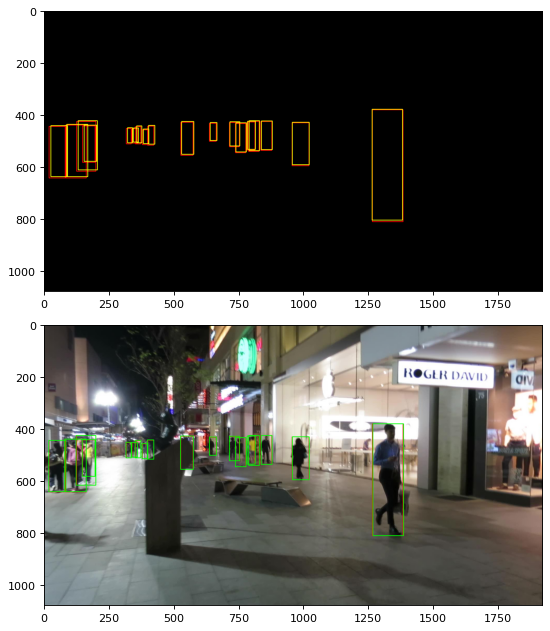

In [50]:
import matplotlib.pyplot as plt

print(f'next frame id: {next_ref_id}')
# original boxes (t + 1)
draw_img = next_ref_frame.copy()
draw_img = cv2.cvtColor(draw_img, cv.COLOR_RGB2BGR)
draw_boxes(draw_img, boxes, color = (255, 0, 0), thickness = 2)

# ecc warpping (t)
draw_board = create_black_board(w_img=w_img, h_img=h_img)
draw_boxes(draw_board, boxes, color = (255, 0, 0), thickness = 2)
draw_boxes(draw_board, w_boxes, color = (255, 255, 0), thickness = 2)

# project back to (t + 1)
print(alpha, beta, fov)
focal_length   = gen_focal_length(w_img, fov)
new_cm         = NewCamera(w_img, h_img, focal_length, focal_length, w_img /2, h_img / 2)
new_rot        = NewRotation(np.array([alpha, beta, 0]), mode = 'ZYX')
cboard_mapping = NewCardBoard(new_cm, new_rot)
xyhw           = cboard_mapping.bbox2xyhw(w_boxes)

d_alpha, d_beta, d_fov, dx, dy, dz = result
# d_alpha, d_beta, d_fov = 0, 0, 0
alpha2         = alpha + d_alpha
beta2          = beta + d_beta
fov2           = fov + d_fov
print(alpha2, beta2, fov2, dx, dy, dz)
focal_length   = gen_focal_length(w_img, fov2)
new_cm         = NewCamera(w_img, h_img, focal_length, focal_length, w_img /2, h_img / 2)
new_rot        = NewRotation(np.array([alpha2, beta2, 0]), mode = 'ZYX')
cboard_mapping = NewCardBoard(new_cm, new_rot, np.array([dx, dy, dz]))
new_boxes      = cboard_mapping.xyhw2bbox(xyhw)
draw_boxes(draw_img, new_boxes, color = (0, 255, 0), thickness = 2)

fig = plt.figure(figsize=(8, 8), dpi=80, tight_layout=True)
font_size = 20
ax = fig.subplots(2, 1)
ax[0].imshow(draw_board)
ax[1].imshow(draw_img)

In [51]:
def box_loss(boxes1, boxes2):
    box_centers1 = boxes1[:,     :2] + boxes[:, 2:] / 2
    box_centers2 = boxes2[:, :2]     + boxes2[:, 2:] / 2
    loss         = np.linalg.norm(box_centers1 - box_centers2, axis = 1).mean()
    return loss

In [52]:
# calbiration incremental calibration
import cv2 as cv
from cardboard.new_cardboard_v2 import CardBoard as NewCardBoard
from cardboard.camera_utils import Camera as NewCamera
from cardboard.geometry_3d import Rotation as NewRotation
ref_frame_id = 50
print(f'reference frame: {ref_frame_id}')
print(f'calibration results: alpha {round(alpha, 2)} beta {round(beta, 2)} fov {round(fov, 2)}')

alpha_t, beta_t, fov_t = alpha, beta, fov
focal_length   = gen_focal_length(w_img, fov_t)
new_cm         = NewCamera(w_img, h_img, focal_length, focal_length, w_img /2, h_img / 2)
new_rot        = NewRotation(np.array([alpha_t, beta_t, 0]), mode = 'ZYX')
cb_mapping     = NewCardBoard(new_cm, new_rot)

calib_inter_res_dir = os.path.join(calib_res_dir, f'{seq_name}_calib_figures')
gen_dir(calib_inter_res_dir)

for i in range(1, 100):

    print('----------------------------------------------')
    # compute ecc
    start_time = time.time()
    next_ref_id     = ref_frame_id + 1
    ref_frame       = cv.imread(boxloader.img_dir + '/{:06d}.jpg'.format(ref_frame_id + 1))
    next_ref_frame  = cv.imread(boxloader.img_dir + '/{:06d}.jpg'.format(next_ref_id  + 1))
    ecc_coef        = boxloader.ecc(next_ref_frame, ref_frame)
    ecc_coef        = np.expand_dims(ecc_coef, axis = 0)
    end_time = time.time()
    # print(f'ecc time: {end_time - start_time}')
    # ecc warpping
    start_time = time.time()
    tracks_in_frame = boxloader.raw_tracks[:, ref_frame_id : next_ref_id, :]
    box_mask        = tracks_in_frame[:, :, -1] > 0
    warp_tracks     = boxloader.map_to_ref(ecc_coef, tracks_in_frame)
    end_time = time.time()
    # print(f'box warpping time: {end_time - start_time}')
    # print(boxes.shape)
    # valid boxes
    boxes           = tracks_in_frame[box_mask, :].squeeze()
    w_boxes         = warp_tracks[box_mask, :].squeeze()
    loss1           = box_loss(boxes, w_boxes)

    focal_length = gen_focal_length(w_img, fov_t)
    cam_vec = np.array([focal_length, focal_length, w_img / 2, h_img / 2])
    new_camera = cb_mapping.get_camera()
    new_camera.update_intrisic(cam_vec)
    new_rotation = cb_mapping.get_rotation()
    new_rotation.set_angles(np.array([alpha_t, beta_t, 0]), mode = 'ZYX')
    cb_mapping.set_camera(new_camera)
    cb_mapping.set_rotation(new_rotation)
    cb_mapping.set_transition(np.array([0, 0, 0]))
    xyhw = cb_mapping.bbox2xyhw(w_boxes)

    # calibration
    start_time = time.time()
    dbound   = (-wbound[1], wbound[1])
    bounds   = ((-5, 5), (-5, 5), (-5, 5), dbound, dbound, dbound)
    initals  = (alpha_t, beta_t, fov_t)
    result, loss_val = ecc_calib_v2(boxes, w_boxes, initals, bounds, cb_mapping)
    end_time = time.time()

    # print(f'box calibration time: {end_time - start_time}')
    d_alpha, d_beta, d_fov, dx, dy, dz = result
    alpha_t, beta_t, fov_t = alpha_t + d_alpha, beta_t + d_beta, fov_t + d_fov
    print(f'incremental results for frame: {next_ref_id}')
    print(f'loss before optimization: {loss1}')
    print(f'd_alpha {round(d_alpha, 4)} d_beta {round(d_beta, 4)} d_fov {round(d_fov, 4)}')
    print(f'dx {round(dx, 4)} dy {round(dy, 4)} dz {round(dz, 4)} loss {loss_val}')
    print(f'updated alpha {round(alpha_t, 4)} beta {round(beta_t, 4)} fov {round(fov_t, 4)} T = {[round(dx, 4), round(dy, 4), round(dz, 4)]}')

    focal_length = gen_focal_length(w_img, fov_t)
    cam_vec = np.array([focal_length, focal_length, w_img / 2, h_img / 2])
    new_camera = cb_mapping.get_camera()
    new_camera.update_intrisic(cam_vec)
    new_rotation = cb_mapping.get_rotation()
    new_rotation.set_angles(np.array([alpha_t, beta_t, 0]), mode = 'ZYX')
    cb_mapping.set_camera(new_camera)
    cb_mapping.set_rotation(new_rotation)
    cb_mapping.set_transition(np.array([dx, dy, dz]))
    new_boxes = cb_mapping.xyhw2bbox(xyhw)

    # create a drawing board
    draw_board = create_black_board(w_img, h_img) * 125
    draw_boxes(draw_board, boxes,     color = (0,   0, 255), thickness = 2)
    draw_boxes(draw_board, w_boxes,     color = (0,   255, 255), thickness = 2)
    draw_text(draw_board, f'frame id: {next_ref_id}', pt = (5, 60), color = (0, 255, 0), scale = 2,  thickness = 3)

    # draw results
    draw_img = next_ref_frame.copy()
    draw_boxes(draw_img, boxes,     color = (0,   0, 255), thickness = 2)
    draw_boxes(draw_img, new_boxes, color = (0,   255, 0), thickness = 2)

    # concat results
    draw_concat = cv.vconcat([draw_board, draw_img])

    cv.imwrite(calib_inter_res_dir + f'/{next_ref_id}.png', draw_concat)

    ref_frame_id = next_ref_id


reference frame: 50
calibration results: alpha 82.58 beta -0.83 fov 74.63
----------------------------------------------
incremental results for frame: 51
loss before optimization: 6.962082664530226
d_alpha -0.0496 d_beta 0.1387 d_fov -0.6123
dx 0.0107 dy 0.1368 dz 0.2511 loss 1.4142680277802417
updated alpha 82.5275 beta -0.6879 fov 74.0192 T = [0.0107, 0.1368, 0.2511]
----------------------------------------------
incremental results for frame: 52
loss before optimization: 6.314210694279366
d_alpha -0.0341 d_beta 0.0688 d_fov -0.6229
dx -0.1616 dy 0.2554 dz 0.2579 loss 1.3029821579190162
updated alpha 82.4933 beta -0.6191 fov 73.3963 T = [-0.1616, 0.2554, 0.2579]
----------------------------------------------
incremental results for frame: 53
loss before optimization: 7.509552875229198
d_alpha -0.0283 d_beta 0.0106 d_fov -0.727
dx -0.0961 dy -0.2785 dz 0.2178 loss 1.8157284465718837
updated alpha 82.465 beta -0.6085 fov 72.6694 T = [-0.0961, -0.2785, 0.2178]
-------------------------

In [9]:
# start_frame = args.start
# time_window  = args.window
proj_name    = 'calib_v4'         # dynamic update for a moving camera
frame_window = time_window * seq_info['fps']
print(frame_window)
start_frame  = 0

for start_frame_id in range(num_frames):
    end_frame_id = start_frame_id + frame_window
    ref_frame_id = start_frame_id + frame_window // 2
    # boxes = boxloader.get_boxe_pairs_by_window(start_frame, end_frame - start_frame)
    boxes = boxloader.get_ecc_warpped_boxes(start_frame_id, frame_window)
    print(f'-------------------------------------------------------------------------')
    print(f'start_frame: {start_frame_id}, end_frame: {start_frame_id + frame_window - 1}, ref_frame: {ref_frame_id}, samples: {boxes.shape}')
    num_camples = boxes.shape[0]

    # perform calibration
    start_time = time.time()
    bounds   = ((20, 100), (-10, 10), (30, 150))
    result, loss_val = dec_calib(boxes, bounds, a_view, use_core = use_core)
    end_time   = time.time()
    duration = end_time - start_time
    # print(f'duration: {round(duration, 2)}s')

    alpha, beta, fov = result
    alpha, beta, fov = float(alpha), float(beta), float(fov)
    print(f'alpha: {round(alpha, 2)}, beta: {round(beta, 2)}, fov: {round(fov, 2)}, loss:{round(loss_val, 6)} dur: {round(duration, 2)} s')

    cam_info = {'w_img': w_img, 'h_img': h_img,
                'alpha': alpha, 'beta': beta, 'fov': fov}

    cam_info_file = calib_res_dir + f'/{seq_name}_{start_frame_id}_{end_frame_id}.json' if use_gt else calib_res_dir + f'/{seq_name}_trk.json'
    save_to_json(cam_info_file, cam_info)

    # visualize calibration result
    track_dir     = os.path.join(root_dir, 'results', proj_name, dataset_name, seq_name)
    if not use_gt: track_dir += '_trk'
    res_dir       = track_dir + f'/ground_floor_{frame_window}'
    gen_dir(res_dir)

    dis_dir   = track_dir + f'/distribution_{frame_window}'
    gen_dir(dis_dir)
    vis_board = vis_box_pairs(w_img, h_img, boxes)
    cv2.imwrite(dis_dir + f'/{seq_name}_{start_frame_id}-{end_frame_id}_box_distributioin.png', vis_board)

    all_tracks    = boxloader.raw_tracks
    all_track_ids = boxloader.track_ids

    # print(all_tracks.shape)
    img_size = h_img // 2

    xy_ranges = get_xy_ranges(a_view, all_tracks)  # define xy ranges for visualization

    img_dir   = os.path.join(root_dir, 'datasets', dataset_name, subset, seq_name, 'img1')

    # for frame_id in range(num_frames):
    frame_id = (start_frame_id + end_frame_id) // 2

    if dataset_name == 'dancetrack':
        img_file = img_dir + '/{:08d}.jpg'.format(frame_id + 1)
    else:
        img_file = img_dir + '/{:06d}.jpg'.format(frame_id + 1)

    frame     = cv2.imread(img_file)
    
    boxes        = all_tracks[:, frame_id, :]
    box_mask     = boxes[:, 2] * boxes[:, 3] > 0
    boxes        = boxes[box_mask, :]

    track_ids    = all_track_ids[box_mask]
    xyh          = a_view.compute_xyh_from_boxes(boxes)
    bot_centers  = get_box_pts(boxes)

    draw_img = frame.copy()
    for i in range(bot_centers.shape[0]):
        track_id = track_ids[i]
        draw_text(draw_img, f'frame_id: {frame_id}', (5, 20), color = (0, 255, 0), scale = 1, thickness = 2)
        draw_corners(draw_img, bot_centers[i, :].reshape((-1, 2)), color = RANDOM_COLORS[track_id].tolist(), dot_size = 3)
        draw_box(draw_img, boxes[i, :], color = RANDOM_COLORS[track_id].tolist(), thickness = 2)

    if bot_centers.shape[0] == 0: continue

    # draw xyh in aerial view
    vis_3d_draw = vis_xyz_as_images(xyh, track_ids, xy_ranges, img_size = img_size, dot_size = 5, 
                        scale = 1, thickness = 2, orient_angle = 0, r = 10, arrow_thickness = 2, colors = RANDOM_COLORS)
    blk_board   = create_black_board(img_size, h_img)
    blk_board[h_img // 2 - img_size // 2: h_img // 2 + img_size // 2, :] = vis_3d_draw

    # draw parameters in figure
    row_size    = 35
    py1 = h_img // 2 + img_size // 2 + row_size
    draw_text(blk_board, f'al, bt, fov: {round(alpha, 2)} {round(beta, 2)} {round(fov, 2)}', (5, py1), color = (0, 255, 0), scale = 1, thickness = 3)
    py2 = h_img // 2 + img_size // 2 + row_size * 2
    draw_text(blk_board, f'samples:{num_camples}, loss:{round(loss_val, 3)}', (5, py2), color = (0, 255, 0), scale = 1, thickness = 3)

    img_pts = a_view.project_xyh_to_img(xyh)
    img_pts = np.int16(img_pts)

    thickness = 2
    for i in range(img_pts.shape[0]):
        top_pt = img_pts[i, 0, :]
        bot_pt = img_pts[i, 1, :]
        track_id = track_ids[i]
        cv2.line(draw_img, top_pt, bot_pt, (0, 0, 255), thickness)

    concat = cv2.hconcat([draw_img, blk_board])
    cv2.imwrite(res_dir + f'/image_{seq_name}_{start_frame_id}-{end_frame_id}_{round(alpha, 2)}_{round(beta, 2)}_{round(fov, 2)}_gt_{use_gt}.png', concat)

    # start_frame += frame_window

90
-------------------------------------------------------------------------
start_frame: 0, end_frame: 89, ref_frame: 45, samples: (72, 2, 4)
alpha: 83.98, beta: -2.6, fov: 74.16, loss:0.043514 dur: 3.86 s
-------------------------------------------------------------------------
start_frame: 1, end_frame: 90, ref_frame: 46, samples: (72, 2, 4)
alpha: 83.78, beta: -2.28, fov: 76.26, loss:0.043285 dur: 4.29 s
-------------------------------------------------------------------------
start_frame: 2, end_frame: 91, ref_frame: 47, samples: (71, 2, 4)
alpha: 83.94, beta: -2.32, fov: 76.66, loss:0.044529 dur: 3.87 s
-------------------------------------------------------------------------
start_frame: 3, end_frame: 92, ref_frame: 48, samples: (70, 2, 4)
alpha: 83.72, beta: -2.14, fov: 76.19, loss:0.052006 dur: 4.3 s
-------------------------------------------------------------------------
start_frame: 4, end_frame: 93, ref_frame: 49, samples: (63, 2, 4)
alpha: 83.18, beta: -1.38, fov: 78.39, 

(188, 750, 4)
[[ 1.35523880e+00  9.07520279e-02 -4.83155861e+01]
 [ 4.27525081e-02  1.28491175e+00 -2.22263985e+01]
 [ 5.04710188e-04  3.87536507e-04  1.00000000e+00]]
(200, 3, 3) (188, 200, 4)
(188, 200, 4)
(1, 200, 3, 3)
(188, 200, 3, 3)
(150400, 3, 3) (150400, 3, 1)
(150400, 3, 1)
(188, 200, 4)
boxes: 23
(188, 4) [0. 0. 0. 0.]


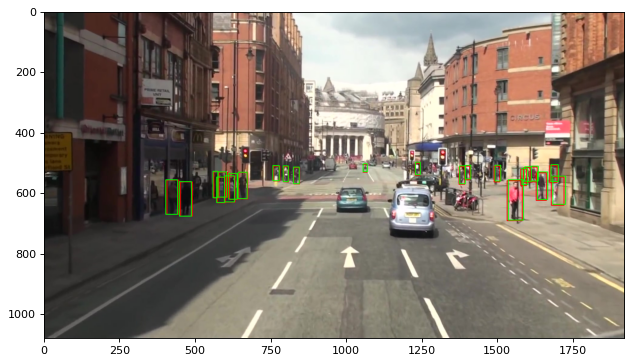

In [ ]:
import matplotlib.pyplot as plt

tracks  = boxloader.raw_tracks
print(tracks.shape)

print(ecc_coefs[0, :])
num      = 200
trks     = tracks[:,:num,:]

ecc_coef = ecc_coefs[:num, :]

print(ecc_coef.shape, trks.shape)
x        = map_to_ref(ecc_coef, trks, dsample = 4)

print(x.shape)


# test for the first two frames
frame_id = 48
frame    = cv.imread(img_dir + '/{:06d}.jpg'.format(frame_id +1))
frame    = cv2.cvtColor(frame, cv.COLOR_RGB2BGR)
draw_fr  = frame.copy()
# box      = tracks[:,frame_id, :]
box      = x[:, frame_id, :]
box0     = trks[:, frame_id, :]
box_mask = box[:, -1] > 0
print(f'boxes: {box_mask.sum()}')
print(box.shape, box[0, :])

draw_boxes(draw_fr, box0[box_mask], color = (255, 0, 0), thickness = 2)
draw_boxes(draw_fr, box[box_mask], color = (0,    255, 0), thickness = 2)


fig = plt.figure(figsize=(8, 8), dpi=80, tight_layout=True)
font_size = 20
ax = fig.subplots(1, 1)
cax = ax.imshow(draw_fr)